In [1]:
#from helper import differential_equation_loss, optimizer_function_factory
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [2]:
# el data set
import tensorflow as tf
# Ruta del archivo TFRecord que deseas cargar
input_path = "dataset.tfrecord"


# Función para parsear un ejemplo TFRecord
def parse_dataset(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([3], tf.float32),
        'v': tf.io.FixedLenFeature([3], tf.float32)
    }
    dataset = tf.io.parse_single_example(example_proto, feature_description)
    return dataset['x'], dataset['v']

# Cargar el dataset desde el archivo TFRecord
dataset = tf.data.TFRecordDataset(input_path)
dataset = dataset.map(parse_dataset)


def head_dataset(dataset):
    # Ahora puedes iterar sobre el dataset para leer los datos
    print_n = 5
    for data in dataset:
        print(data)
        print_n -= 1
        if print_n < 0:
            break

head_dataset(dataset)

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.9167395, 3.805452 , 3.721134 ], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.3183789 , -0.934036  , -0.75950456], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.805452 , 3.721134 , 3.6490405], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.934036  , -0.75950456, -0.67820454], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.721134 , 3.6490405, 3.582606 ], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.75950456, -0.67820454, -0.64235467], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.6490405, 3.582606 , 3.5185351], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.67820454, -0.64235467, -0.6291701 ], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.582606 , 3.5185351, 3.4551263], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy

In [3]:
# Define el tamaño del lote (batch)
batch_size = 32

# Mezcla los datos y crea lotes
dataset = dataset.shuffle(buffer_size=1000)  # Opcional: si deseas mezclar los datos
dataset = dataset.batch(batch_size)

In [4]:
def lendataset(dataset):
    size = 0
    for batch_x, batch_v in dataset:
        # Realiza operaciones con el lote de datos
        size += batch_x.shape[0]
    return size
    
lendataset(dataset)

49000

## El modelo
El modelo tiene una sola entrada y una sola salida; quiere decir que es necesario conocer $x_k$ para entonces predecir $x_{k+1}$, el modelo se encarga de predecir el siguiente paso temporal,
Este hecho permite calcular el momentum a partir del modelo; por tanto hay varios constrains a tener en cuenta para optimizar esto:

- $$p = \frac{dx}{dt} = \frac{x_{k+1} - x_{k-1}}{2h}$$

- $$\frac{d^2x}{dt^2} = \frac{x_{k+1} - 2 x_k + x_{k-1}}{h^2}$$

## leer el dataset

In [5]:
# Supongamos que tienes 1000 elementos en tu dataset
total_size = lendataset(dataset)
# Supongamos que tienes un tamaño de lote (batch_size) definido previamente
batch_size = 32

# Define el tamaño de los conjuntos de entrenamiento, validación y prueba
train_p = 0.8
valid_p = 0.1
test_p = 1 - train_p - valid_p

train_size = int( total_size * train_p )
valid_size = int( total_size * valid_p )
test_size = int( total_size * test_p )

# Divide el dataset en tres conjuntos
train_dataset = dataset.take(train_size // batch_size)
valid_dataset = dataset.skip(train_size // batch_size).take(valid_size // batch_size)

test_dataset = dataset.skip(
    train_size // batch_size + valid_size // batch_size).take(test_size // batch_size)


print("train size", lendataset(train_dataset))
print("valid size", lendataset(valid_dataset))
print("test size", lendataset(test_dataset))


train size 39200
valid size 4896
test size 4896


In [6]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [7]:
head_dataset(train_dataset)

(<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[ 1.9598137 ,  1.8956125 ,  1.8209435 ],
       [ 1.8914576 ,  1.9554878 ,  1.9920151 ],
       [-1.4876721 , -1.3545678 , -1.2130972 ],
       [-1.7550095 , -1.8637059 , -1.9416403 ],
       [-0.21373801, -0.01005892,  0.20392005],
       [-2.0073025 , -2.0077384 , -1.9891989 ],
       [-2.7862294 , -2.7256453 , -2.65803   ],
       [ 0.782507  ,  1.0078785 ,  1.2230611 ],
       [ 3.582606  ,  3.5185351 ,  3.4551263 ],
       [-1.7655712 , -1.6826627 , -1.5905001 ],
       [-1.9449435 , -1.989854  , -2.0099294 ],
       [ 2.0197997 ,  2.024845  ,  2.0100539 ],
       [ 2.3185127 ,  2.2251413 ,  2.1280882 ],
       [-1.8974319 , -1.9661478 , -2.0071504 ],
       [-2.8895001 , -2.8961632 , -2.8760862 ],
       [-0.6656486 , -0.4902728 , -0.30309474],
       [-0.6650722 , -0.8920449 , -1.1119938 ],
       [ 1.9641441 ,  2.0287964 ,  2.0649166 ],
       [ 1.3365942 ,  1.215235  ,  1.0845531 ],
       [-2.0465164 , -2.0717843 , -2.0

In [8]:
# Convierte las listas de tuplas en tensores
def list_of_tuples_to_tensors(dataset_list):
    x_list, v_list = zip(*dataset_list)
    x_tensor = tf.convert_to_tensor(x_list, dtype=tf.float32)
    v_tensor = tf.convert_to_tensor(v_list, dtype=tf.float32)
    return x_tensor, v_tensor

train_dataset = list_of_tuples_to_tensors(train_dataset)
valid_dataset = list_of_tuples_to_tensors(valid_dataset)
test_dataset = list_of_tuples_to_tensors(test_dataset)

In [9]:
xk_train = train_dataset[0][:, :, 0]
dxk_dt_train = train_dataset[1][:, :,0]

xkp1_train = train_dataset[0][:, :,1]
xkp2_train = train_dataset[0][:, :,2]
dxdt_train = train_dataset[1][:, :,1]

Z_train =tf.stack([xk_train, dxk_dt_train], axis=-1)
Z_train.shape

Z_target = tf.stack([xkp1_train, xkp2_train, dxdt_train], axis=-1)
Z_target.shape

TensorShape([1225, 32, 3])

In [10]:
xk_valid = valid_dataset[0][:, :, 0]
dxk_dt_valid = valid_dataset[1][:, :,0]

xkp1_valid = valid_dataset[0][:, :,1]
xkp2_valid = valid_dataset[0][:, :,2]
dxdt_valid = valid_dataset[1][:, :,1]

Z_valid =tf.stack([xk_valid, dxk_dt_valid], axis=-1)
Z_valid.shape

Z_target_valid = tf.stack([xkp1_valid, xkp2_valid, dxdt_valid], axis=-1)
Z_target_valid.shape


TensorShape([153, 32, 3])

In [11]:
xk_test = test_dataset[0][:, :, 0]
dxk_dt_test = test_dataset[1][:, :,0]

xkp1_test = test_dataset[0][:, :,1]
xkp2_test = test_dataset[0][:, :,2]
dxdt_test = test_dataset[1][:, :,1]

Z_test =tf.stack([xk_test, dxk_dt_test], axis=-1)
Z_test.shape

Z_target_test = tf.stack([xkp1_test, xkp2_test, dxdt_test], axis=-1)
Z_target_test.shape

TensorShape([153, 32, 3])

# Model

In [12]:
class ResidualBlock(layers.Layer):
    def __init__(self, n_layers=4, n_neuron=64, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.input_layer = layers.Dense(1, activation=None)
        self.input_layer.trainable = False
        self.hidden = [
            layers.Dense(n_neuron, activation=activation,
                kernel_initializer="he_normal")
            for _ in range(n_layers)
        ]
        self.outputlayer = layers.Dense(1, activation=None)
    
    def call(self, inputs):
        Z = self.input_layer(inputs)
        for layer in self.hidden:
            Z = layer(Z)
        return self.outputlayer(Z) + self.input_layer(inputs)

In [13]:
resblock =  ResidualBlock(4, 64, 'tanh')
resblock(xk_train)

<tf.Tensor: shape=(1225, 1), dtype=float32, numpy=
array([[-0.375822 ],
       [ 1.2450833],
       [ 1.714427 ],
       ...,
       [-1.3941758],
       [ 1.6576098],
       [ 2.2865105]], dtype=float32)>

In [14]:
class ResidualRegressor(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        #self.flatten = layers.Flatten()  # Aplana los datos
        self.input_layer = layers.Dense(2, activation=None)
        #self.input_layer.trainable = False
        self.resblock = ResidualBlock(4, 64, 'tanh')
    

    def call(self, inputs):

        # input (x_k, p_k)
        Z = self.input_layer(inputs)

        xk = Z[:,:,0]
        pk = Z[:,:,1]
        # calcula x_k+1
        xkp1 = self.resblock(xk) + pk
        # # calcula x_k+2
        xkp2 = self.resblock(xkp1) + pk
        

        # derivada centrada
        # f' = (f(x+h) - f(x-h) )/ 2h + O(h^2)
        # asumimos h=1
        dxdt = ( xkp2 - xk )/2

        return tf.stack([xkp1, xkp2, dxdt], axis=-1)


model = ResidualRegressor()
# ... model build

In [1]:
# construir el modelo para keras hyperparameter tunning
from keras_tuner import RandomSearch

def build_model(hp):
    model = ResidualRegressor()

    # Tune the learning rate, beta_1 and beta_2 for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_beta_1 = hp.Float('beta_1', min_value=0.80, max_value=0.95, step=0.01)
    hp_beta_2 = hp.Float('beta_2', min_value=0.95, max_value=0.999, step=0.0001)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2),
                loss='mse', 
                metrics=['mean_absolute_error'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=6,
    executions_per_trial=5)

tuner.search(Z_train, Z_target, epochs=100, validation_data=(Z_valid, Z_target_valid))

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")
print(f"The optimal beta_1 for the optimizer is {best_hps.get('beta_1')}.")
print(f"The optimal beta_2 for the optimizer is {best_hps.get('beta_2')}.")

Using TensorFlow backend
Reloading Tuner from .\untitled_project\tuner0.json


NameError: name 'Z_train' is not defined

In [33]:
learning_rate = best_hps.get('learning_rate')

0.001

In [22]:
# Configs
epochs = 200

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.86, beta_2=0.999
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("checkpoint1", save_weights_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [23]:
model.compile(optimizer=optimizer, loss='mse')

# entrena el modelo
history = model.fit(Z_train, Z_target, epochs=epochs, validation_data=(Z_valid, Z_target_valid),
    callbacks=[checkpoint_cb,early_stopping_cb])


Epoch 1/200
39/39 [==============================] - 2s 11ms/step - loss: 1.0952 - val_loss: 1.0415
Epoch 2/200
39/39 [==============================] - 0s 6ms/step - loss: 1.0936 - val_loss: 1.0400
Epoch 3/200
39/39 [==============================] - 0s 6ms/step - loss: 1.0930 - val_loss: 1.0384
Epoch 4/200
39/39 [==============================] - 0s 5ms/step - loss: 1.0933 - val_loss: 1.0374
Epoch 5/200
39/39 [==============================] - 0s 6ms/step - loss: 1.0952 - val_loss: 1.0400
Epoch 6/200
39/39 [==============================] - 0s 5ms/step - loss: 1.0971 - val_loss: 1.0410
Epoch 7/200
39/39 [==============================] - 0s 6ms/step - loss: 1.0940 - val_loss: 1.0381
Epoch 8/200
39/39 [==============================] - 0s 6ms/step - loss: 1.0928 - val_loss: 1.0376
Epoch 9/200
39/39 [==============================] - 0s 6ms/step - loss: 1.0926 - val_loss: 1.0378
Epoch 10/200
39/39 [==============================] - 0s 6ms/step - loss: 1.0934 - val_loss: 1.0384
Epoch 11

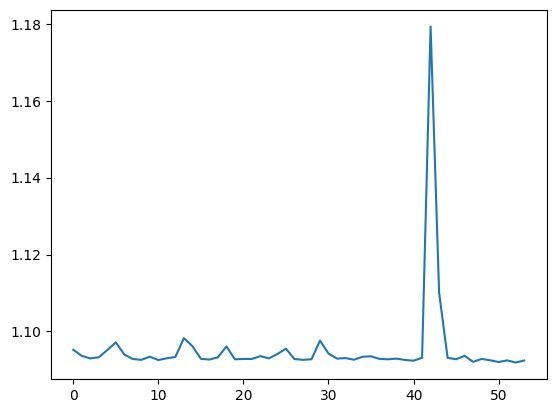

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])


In [25]:
head_dataset(train_dataset)

tf.Tensor(
[[[-1.524127   -1.415228   -1.2973711 ]
  [-0.9954192  -0.84761125 -0.689081  ]
  [ 0.45238012  0.2649383   0.06589429]
  ...
  [-1.6132295  -1.4876721  -1.3545678 ]
  [-0.5163594  -0.7550096  -0.9910703 ]
  [ 2.0174515   2.0188239   2.0009506 ]]

 [[ 2.8153667   2.8454626   2.8419976 ]
  [ 0.91208214  0.7570366   0.59089935]
  [ 1.2721776   1.474265    1.6505156 ]
  ...
  [-2.29003    -2.1952088  -2.0966284 ]
  [ 1.2422286   1.4493471   1.6311622 ]
  [-0.2220572  -0.44480726 -0.6721269 ]]

 [[ 0.97496355  1.1939967   1.396165  ]
  [ 1.4546491   1.3427541   1.2218388 ]
  [ 3.4651332   3.6433475   3.7112458 ]
  ...
  [-2.0402691  -2.0388746  -2.0185146 ]
  [ 1.5526437   1.4490544   1.3365942 ]
  [-1.1330619  -0.9954192  -0.84761125]]

 ...

 [[-1.9695039  -2.007407   -2.020742  ]
  [ 2.306783    2.2127488   2.1149747 ]
  [ 0.78207207  1.004182    1.2156267 ]
  ...
  [-1.5416813  -1.4320158  -1.31377   ]
  [-0.8381676  -1.0767158  -1.3026358 ]
  [-1.3708588  -1.5471597  -1.697

In [27]:

# Evalúa el modelo en el conjunto de validación
validation_loss = model.evaluate(Z_valid, Z_target_valid)
print("Validation Loss:", validation_loss)


5/5 [==============================] - 0s 2ms/step - loss: 1.0341
Validation Loss: 1.034102439880371


# Comparar

Tomar la trayectoria de una particula y comparar como resulta una trayectoria completamente generada por el modelo